In [0]:
import gym
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import animation
from collections import deque
import time
import torch.nn as nn
import torch
cuda = torch.cuda.is_available()
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from functools import reduce
import torch.nn.functional as F

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
env = gym.make("PongDeterministic-v4")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# dueling used by Higgsfield (cf. https://github.com/higgsfield/RL-Adventure/blob/master/3.dueling%20dqn.ipynb)
def compute_loss(ss, aa, rr, ss1, dd):
    for i in range(len(aa)):
        if aa[i] > 0: aa[i] -= 1
            
    state      = Variable(torch.from_numpy(np.stack(ss)).float().to(device))
    next_state = Variable(torch.from_numpy(np.stack(ss1)).float().to(device))
    action     = Variable(torch.from_numpy(np.stack(aa)).long().to(device))
    reward     = Variable(torch.from_numpy(np.stack(rr)).float().to(device))
    done       = Variable(torch.from_numpy(np.stack(dd)).float().to(device))

    q_values      = policy_dqn(state)
    q_values_next = policy_dqn(next_state)
    next_q_values = target_dqn(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.gather(1, torch.max(q_values_next, 1)[1].unsqueeze(1)).squeeze(1)

    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    policy_dqn.optimizer.zero_grad()
    loss.backward()
    policy_dqn.optimizer.step()
    
    return loss

In [0]:
# preprocessing used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)

In [0]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)

    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

replay #: 1000


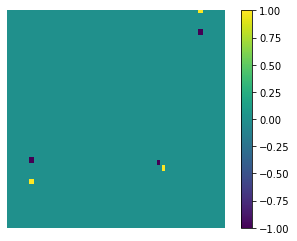

replay #: 2000


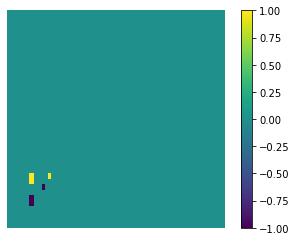

replay #: 3000


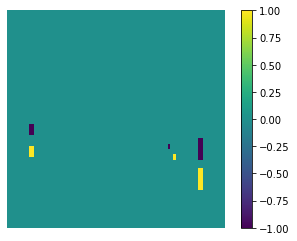

replay #: 4000


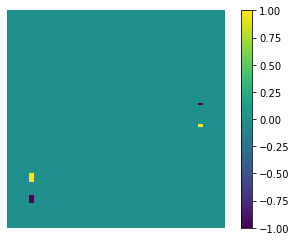

replay #: 5000


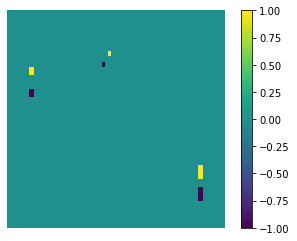

replay #: 6000


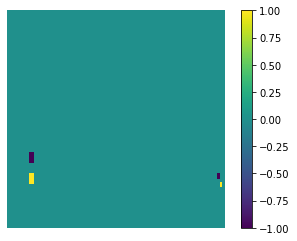

replay #: 7000


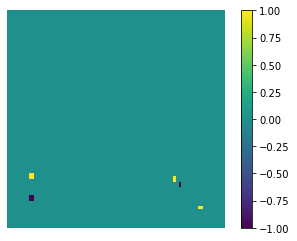

replay #: 8000


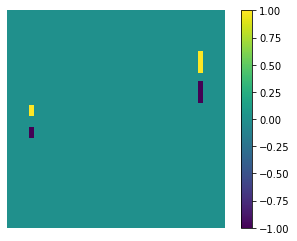

replay #: 9000


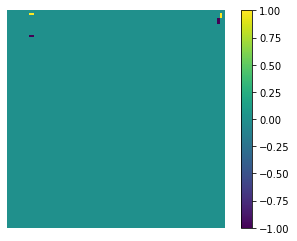

replay #: 10000


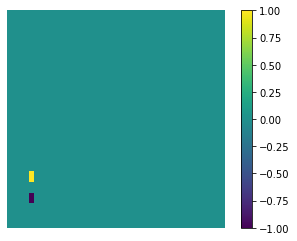

In [7]:
replay_memory_capacity = 50000
prefill_memory = True

replay_memory = ReplayMemory(replay_memory_capacity)

def sample_action():
    n = np.random.uniform(0,1)
    if n <= 1/3:
        return 0
    elif n <= 2/3:
        return 2
    else:
        return 3

if prefill_memory:

    env.reset()
    prev_input = np.zeros((80,80))
    for i in range(15):
        env.step(0)
    state0,_,_,_ = env.step(0)
    cur_input = prepro(state0)
    state = (cur_input - prev_input).reshape(1,80,80)
    prev_input = cur_input 

    while replay_memory.count() <= 0.2*replay_memory_capacity:
        action = sample_action()
        state_raw, reward, done, _ = env.step(action)
        cur_input = prepro(state_raw)
        state1 = (cur_input - prev_input).reshape(1,80,80)
        replay_memory.add(state, action, reward, state1, done)
        if not done:
            prev_input,state = cur_input,state1
        else:
            env.reset()
            for i in range(15):
                env.step(0)
            state_raw,_,_,_ = env.step(0)
            prev_input = prepro(state_raw).reshape(1,80,80)
            state = prev_input
            
        if replay_memory.count() % 1000 == 0:
            print('replay #:',replay_memory.count())
            patch = plt.imshow(state1[0])
            plt.axis('off')
            plt.colorbar()
            plt.show()

In [0]:
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

In [0]:
class DuelingCnnDQN(nn.Module):
    def __init__(self, input_features = 1568, output_layer = 3):
        super(DuelingCnnDQN,self).__init__()

        self.out = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 1)
        )
            

            
        self.advantage = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, output_layer)
        )

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=4, kernel_size = 5, stride = 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(4,16,5,2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16,32,5,2),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self,x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        out = self.out(x)
        return out + advantage - advantage.mean()

    #sum squared diff
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self,new_params,tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [0]:
num_episodes = 1000
episode_limit = 1100
batch_size = 32
epsilon = 1
epsilon_start = 1
epsilon_end = 0.02
epsilon_decay_rate = 150*1000
frames_list = []
epsilon_greedy = 1/(num_episodes*0.5)


step_play = 4
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 10000
prefill_memory = True
val_freq = 50 # validation frequency
capture = True


# initialize DQN and replay memory
policy_dqn = DuelingCnnDQN().to(device)
target_dqn = DuelingCnnDQN().to(device)

target_dqn.load_state_dict(policy_dqn.state_dict())

policy_dqn.optimizer = optim.Adam(policy_dqn.parameters(),lr=0.0001)

rewards, lengths, losses, epsilons = [], [], [], []

In [0]:
load = False

if load:
    model_save_name = 'classifier.pt'
    path = F"/content/gdrive/My Drive/" + model_save_name

    checkpoint = torch.load(path)
    policy_dqn.load_state_dict(checkpoint['policy_dqn'])
    target_dqn.load_state_dict(checkpoint['target_dqn'])
    policy_dqn.optimizer.load_state_dict(checkpoint['optimizer'])
    replay_memory = checkpoint['replay_mem']
    episode = checkpoint['epoch']
    epsilon = checkpoint['epsilon']
    loss = checkpoint['loss']

In [0]:
def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


09:45:12 01/03/20 Episode:, 1, reward:,-19.0, frames: ,1683, epsilon: ,0.994, last_100_avgR: ,-19.0
09:45:30 01/03/20 Episode:, 2, reward:,-21.0, frames: ,1573, epsilon: ,0.987, last_100_avgR: ,-20.0
09:45:34 01/03/20 Episode:, 3, reward:,-21.0, frames: ,1303, epsilon: ,0.981, last_100_avgR: ,-20.333333333333332
09:45:38 01/03/20 Episode:, 4, reward:,-21.0, frames: ,1305, epsilon: ,0.974, last_100_avgR: ,-20.5
09:45:43 01/03/20 Episode:, 5, reward:,-21.0, frames: ,1482, epsilon: ,0.968, last_100_avgR: ,-20.6
09:45:47 01/03/20 Episode:, 6, reward:,-21.0, frames: ,1212, epsilon: ,0.962, last_100_avgR: ,-20.666666666666668
09:45:52 01/03/20 Episode:, 7, reward:,-21.0, frames: ,1668, epsilon: ,0.955, last_100_avgR: ,-20.714285714285715
09:45:56 01/03/20 Episode:, 8, reward:,-20.0, frames: ,1356, epsilon: ,0.949, last_100_avgR: ,-20.625
09:46:02 01/03/20 Episode:, 9, reward:,-20.0, frames: ,1813, epsilon: ,0.943, last_100_avgR: ,-20.555555555555557
09:46:07 01/03/20 Episode:, 10, reward:,-2

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


09:49:44 01/03/20 Episode:, 51, reward:,-19.0, frames: ,1686, epsilon: ,0.717, last_100_avgR: ,-20.254901960784313
09:50:07 01/03/20 Episode:, 52, reward:,-21.0, frames: ,1578, epsilon: ,0.712, last_100_avgR: ,-20.26923076923077
09:50:14 01/03/20 Episode:, 53, reward:,-20.0, frames: ,1986, epsilon: ,0.708, last_100_avgR: ,-20.264150943396228
09:50:19 01/03/20 Episode:, 54, reward:,-21.0, frames: ,1482, epsilon: ,0.703, last_100_avgR: ,-20.27777777777778
09:50:24 01/03/20 Episode:, 55, reward:,-20.0, frames: ,1537, epsilon: ,0.699, last_100_avgR: ,-20.272727272727273
09:50:31 01/03/20 Episode:, 56, reward:,-20.0, frames: ,2172, epsilon: ,0.694, last_100_avgR: ,-20.267857142857142
09:50:39 01/03/20 Episode:, 57, reward:,-20.0, frames: ,2265, epsilon: ,0.69, last_100_avgR: ,-20.263157894736842
09:50:44 01/03/20 Episode:, 58, reward:,-19.0, frames: ,1771, epsilon: ,0.685, last_100_avgR: ,-20.24137931034483
09:50:50 01/03/20 Episode:, 59, reward:,-18.0, frames: ,1825, epsilon: ,0.681, last_

KeyboardInterrupt: ignored

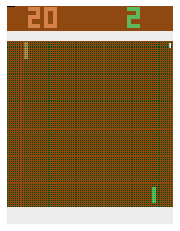

In [13]:
for episode in range(num_episodes):

    if load:
       episode += checkpoint['epoch']
    
    frames = 0
    ep_reward, ep_loss = 0, 0
    # init new episode
    env.reset()
    prev_input = np.zeros((80,80))
    for i in range(15):
        env.step(0)
    state0,_,_,_ = env.step(0)
    cur_input = prepro(state0)
    state = (cur_input - prev_input).reshape(1,80,80)
    prev_input = cur_input

    #append frames to create a giffy
    if capture: frames_list.append(state0)

    for frame in range(episode_limit):
        # select action with epsilon-greedy strategy
        for step in range(step_play):
            if np.random.rand() < epsilon:
                action = sample_action()
            else:
                with torch.no_grad():
                    s_tmp = torch.from_numpy(state.reshape(1,1,80,80)).float().to(device)
                    action = policy_dqn(s_tmp).argmax().item()
                    action +=1 if action != 0 else action 

            state_raw, reward, done, _ = env.step(action)

            # Append frames to giffy
            if capture: frames_list.append(state_raw)

            cur_input = prepro(state_raw)
            state1 = (cur_input - prev_input).reshape(1,80,80)
            replay_memory.add(state, action, reward, state1, done)
        
            state = state1
            prev_input = cur_input
            ep_reward += reward
            frames += step
            if done:
                break
                
        if replay_memory.count() >= batch_size:
            batch = replay_memory.sample(batch_size)
            for step in range(step_play):
                batch.extend(replay_memory.sample(batch_size))
            batch = np.array(batch)
            ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
            loss = compute_loss(ss, aa, rr, ss1, dd)
            target_dqn.update_params(policy_dqn.state_dict(), tau)
        ep_loss += loss.item()                 
        if done: 
            break
    if epsilon > 0.01:
        epsilon *= 0.9935
    else:
        epsilon = 0.01
    




    rewards.append(ep_reward)
    print('{} Episode:, {}, reward:,{}, frames: ,{}, epsilon: ,{}, last_{}_avgR: ,{}'.format(
        time.strftime('%X %x'),episode+1, ep_reward, frames, round(epsilon,3), 100,np.mean(rewards[-100:])))

     # save a gif
    if capture:
        gif = F"/content/gdrive/My Drive/Pong_gifs" + str(episode) + '.gif'
        save_frames_as_gif(frames_list, filename=gif)
        capture = False
        frames = []

    # frequency for when to make a giffy
    if (episode+1) % val_freq == 0: # Test setup
        frames_list, capture = [], True
        print('GIF saved')

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/" + model_save_name
torch.save({
    'epoch': episode +1,
    'policy_dqn': policy_dqn.state_dict(),
    'target_dqn': target_dqn.state_dict(),
    'optimizer': policy_dqn.optimizer.state_dict(),
    'replay_mem': replay_memory,
    'epsilon': epsilon,
    'loss': loss
}, path)